## Comparison of different embedding types
In this notebook, we explore how different embeddings look like for the same content -  Presentation Slides. As presentation slides usually contain different modalities, like text, images or illustrations, it might be useful to know whether different types of embeddings are doing a better or worse job regarding the specific slide content. 
We will compare:
- pure text embeddings
- pure vision embeddings
- multi-modal embeddings

The presentation we use is designed for this specific task. Slides are adapted from the [Bio-image Data Science Lectures](https://zenodo.org/records/12623730) from Robert Haase (licensed under CC-BY 4.0). They are changed to explore whether specific changes (e.g. new background, layout, image resolution, contrast, text placement, design elements, language, ...) effect their ability to still group together related slides.

In [2]:
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import torch
from PIL import Image
import requests
import os

# Initialize models
text_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [3]:
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import (
        SystemMessage,
        UserMessage,
        TextContentItem,
        ImageContentItem,
        ImageUrl,
        ImageDetailLevel,
    )
from azure.core.credentials import AzureKeyCredential 


endpoint = "https://models.inference.ai.azure.com"
token = os.environ["GITHUB_TOKEN"]
client = ChatCompletionsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(token),
)

In [4]:
def get_gpt4o_mixed_embedding(client, image_path):
    """
    Generates mixed-modal embeddings using the GitHub Marketplace ChatGPT 4o.

    Parameters
    ----------
    client : ChatCompletionsClient
        An instance of the ChatCompletionsClient for interacting with the GPT-4o model.
    image_path : str
        The file path to the image to be processed.

    Returns
    -------
    list
        The embedding vector generated for the image.

    Raises
    ------
    ValueError
        If the model response does not include the expected embedding.
    """
    from azure.ai.inference.models import ImageContentItem, ImageUrl, ImageDetailLevel

    # Load the image into the required format
    image_content = ImageUrl.load(
        image_file=image_path,
        image_format="png",
        detail=ImageDetailLevel.LOW,
    )

    # Make the API request to the GitHub Marketplace model
    response = client.complete(
        messages=[
            SystemMessage(
                content="You are a professional Data Scientist specializing in Image Data Analysis and Research Data Management."
            ),
            UserMessage(
                content=[
                    ImageContentItem(image_url=image_content)
                ],
            ),
        ],
        model="gpt-4o",
    )

    # Extract the embedding if available
    if hasattr(response.choices[0].message, "embedding"):
        return response.choices[0].message.embedding
    else:
        raise ValueError("The model response does not contain an embedding.")


In [14]:
def get_mixed_embedding(client, image_path):
    """
    Generates a structured description of an image using GPT-4o.

    Parameters
    ----------
    client : ChatCompletionsClient
        The GPT-4o client.
    image_path : str
        Path to the image.

    Returns
    -------
    mixed_embedding:
        Text Embedding of the models anwser. 
    """
    response = client.complete(
        messages=[
            SystemMessage(
                content="You are a professional Data Scientist. Provide a structured description of the image in 1-2 sentences."
            ),
            UserMessage(
                content=[
                    ImageContentItem(
                        image_url=ImageUrl.load(
                            image_file=image_path,
                            image_format="png",
                            detail=ImageDetailLevel.LOW
                        )
                    ),
                ],
            ),
        ],
        model="gpt-4o",
    )

    # Parse structured description from response
    structured_response = response.choices[0].message.content
    
    # Convert the textual response into an embedding
    mixed_embedding = text_model.encode(structured_response)

    return mixed_embedding

In [15]:
# Process PDF Text
def calculate_text_embeddings(pdf_name):    
    text_embeddings = {}
    with pdfplumber.open(pdf_name) as pdf:
        for page_number, page in enumerate(pdf.pages):
            text = page.extract_text() or ""  # Handle empty pages gracefully
            text_embeddings[page_number] = text_model.encode(text)
    return text_embeddings

# Step 2: Process Slides (Visual and Mixed-Modal Embeddings)
def process_slides(slides, client):
    """
    Processes the slides to compute visual and mixed-modal embeddings.

    Parameters
    ----------
    slides : list
        List of images representing the slides.
    client : object
        The initialized client for mixed-modal embedding (GitHub Marketplace ChatGPT 4o).

    Returns
    -------
    list
        A list of dictionaries containing embeddings and slide numbers.
    """
    slide_embeddings = []
    for slide_number, slide_image in enumerate(slides):
        # Save slide image temporarily
        image_path = f"images/slide_{slide_number}.png"
        slide_image.save(image_path)
        
        # Generate visual embedding using CLIP
        inputs = clip_processor(images=slide_image, return_tensors="pt")
        with torch.no_grad():
            visual_embedding = clip_model.get_image_features(**inputs).squeeze().tolist()
        
        # Generate 'mixed-modal' embedding using GPT-4o
        try:
            mixed_embedding = get_mixed_embedding(client, image_path)
        except Exception as e:
            print(f"Error generating GPT-4o embedding for slide {slide_number}: {e}")
            mixed_embedding = None
        
        # Append embeddings
        slide_embeddings.append({
            "slide_number": slide_number,
            "visual_embedding": visual_embedding,
            "mixed_modal_embedding": mixed_embedding,
        })
    return slide_embeddings

In [7]:
from pdf_utilities import load_pdf
pdf_path = "Test_Changes.pdf"  # Replace with your PDF path
slides = load_pdf(pdf_path)  # Load PDF as images

In [8]:
# Make a new directory to store the images in for processing
if not os.path.exists("images"):
    os.makedirs("images")

In [16]:
import pdfplumber

# Calculate the embeddings
text_embeddings = calculate_text_embeddings(pdf_path)
slide_embeddings = process_slides(slides, client)

In [17]:
# Create a DataFrame from visual and mixed-modal embeddings
df = pd.DataFrame(slide_embeddings)

# Add text embeddings to the DataFrame
df["text_embedding"] = df["slide_number"].map(text_embeddings)

#Show the DataFrame
df

,slide_number,visual_embedding,mixed_modal_embedding,text_embedding
0,0,"[0.017524734139442444, 0.521052896976471, -0.2...","[0.2037016, -0.13957044, 0.58438116, -0.126322...","[0.06354387, 0.13842154, 0.15972771, 0.0445101..."
1,1,"[0.14465579390525818, 0.3926692008972168, -0.4...","[0.03365266, -0.042170875, 0.021206953, 0.0076...","[0.17994516, 0.49280676, -0.030679775, 0.24454..."
2,2,"[0.22554218769073486, 0.32437682151794434, -0....","[0.10791883, -0.6559476, 0.9972814, -0.3307552...","[0.104529396, 0.15719108, 0.18121627, 0.065335..."
3,3,"[0.3486047685146332, 0.1341734379529953, 0.141...","[0.26245347, -0.32896823, 0.77976453, -0.19721...","[0.18867822, 0.040159266, 0.2643385, -0.001216..."
4,4,"[0.16091617941856384, 0.3885297179222107, -0.2...","[0.2562374, -0.50005317, 0.76841915, -0.309031...","[0.090500854, 0.15219727, 0.15217209, 0.093864..."
5,5,"[-0.333818256855011, 0.3489265739917755, -0.12...","[-0.1264899, -0.4413804, 0.94339114, -0.609736...","[-0.15701555, -0.2631976, 0.67614114, -0.69411..."
6,6,"[-0.14329558610916138, 0.2888021469116211, -0....","[-0.047574036, -0.37207422, 1.0643729, -0.1844...","[-0.15560323, -0.2640275, 0.6718023, -0.694104..."
7,7,"[-0.20983906090259552, 0.27834552526474, 0.139...","[0.2735368, -0.34414363, 0.7774973, -0.3493248...","[0.06955678, 0.48897076, 0.27902538, 0.4495409..."
8,8,"[0.2828165888786316, 0.3967096507549286, -0.11...","[-0.04222393, -0.31797838, 0.6441511, -0.47936...","[-0.2122357, -0.17941414, 0.5184982, -0.324861..."
9,9,"[0.2555112838745117, 0.5300158858299255, 0.114...","[0.5442298, -0.87012416, 1.0289406, -0.4165003...","[0.8526685, -0.7506917, 0.7696417, -0.6101845,..."


In [18]:
import numpy as np
import umap.umap_ as umap

# Initialize UMAP reducer
reducer = umap.UMAP(n_components=2, random_state=42)

# Initialize a dictionary to store UMAP results
umap_results = {}

# Apply UMAP to each embedding type
for embedding_type in ['text_embedding', 'visual_embedding', 'mixed_modal_embedding']:
    # Convert embeddings to a numpy array
    embeddings = np.array(df[embedding_type].tolist())
    
    # Apply UMAP
    umap_embeddings = reducer.fit_transform(embeddings)
    
    # Store results in the dictionary
    umap_results[embedding_type] = {
        'UMAP0': umap_embeddings[:, 0],
        'UMAP1': umap_embeddings[:, 1]
    }

# Create a new DataFrame to hold UMAP results for each embedding type
df_umap = df.copy()

for embedding_type, umap_data in umap_results.items():
    df_umap[f"{embedding_type}_UMAP0"] = umap_data['UMAP0']
    df_umap[f"{embedding_type}_UMAP1"] = umap_data['UMAP1']

# Output the DataFrame with UMAP results
df_umap

/home/lea/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,slide_number,visual_embedding,mixed_modal_embedding,text_embedding,text_embedding_UMAP0,text_embedding_UMAP1,visual_embedding_UMAP0,visual_embedding_UMAP1,mixed_modal_embedding_UMAP0,mixed_modal_embedding_UMAP1
0,0,"[0.017524734139442444, 0.521052896976471, -0.2...","[0.2037016, -0.13957044, 0.58438116, -0.126322...","[0.06354387, 0.13842154, 0.15972771, 0.0445101...",10.711221,-2.064508,13.107526,-8.449940,14.550907,13.128932
1,1,"[0.14465579390525818, 0.3926692008972168, -0.4...","[0.03365266, -0.042170875, 0.021206953, 0.0076...","[0.17994516, 0.49280676, -0.030679775, 0.24454...",9.757235,-1.687120,10.980680,-8.319244,14.260714,12.504581
2,2,"[0.22554218769073486, 0.32437682151794434, -0....","[0.10791883, -0.6559476, 0.9972814, -0.3307552...","[0.104529396, 0.15719108, 0.18121627, 0.065335...",10.634251,-1.580930,13.380855,-8.936645,12.975011,13.285056
3,3,"[0.3486047685146332, 0.1341734379529953, 0.141...","[0.26245347, -0.32896823, 0.77976453, -0.19721...","[0.18867822, 0.040159266, 0.2643385, -0.001216...",10.286383,-2.007189,12.583560,-9.063151,14.025051,13.111884
4,4,"[0.16091617941856384, 0.3885297179222107, -0.2...","[0.2562374, -0.50005317, 0.76841915, -0.309031...","[0.090500854, 0.15219727, 0.15217209, 0.093864...",10.049945,-2.412397,12.970815,-9.445022,13.476487,13.094070
5,5,"[-0.333818256855011, 0.3489265739917755, -0.12...","[-0.1264899, -0.4413804, 0.94339114, -0.609736...","[-0.15701555, -0.2631976, 0.67614114, -0.69411...",10.952490,-2.940851,12.050576,-9.124169,13.892120,14.012504
6,6,"[-0.14329558610916138, 0.2888021469116211, -0....","[-0.047574036, -0.37207422, 1.0643729, -0.1844...","[-0.15560323, -0.2640275, 0.6718023, -0.694104...",11.335622,-2.391351,12.708400,-7.932402,14.538695,13.787825
7,7,"[-0.20983906090259552, 0.27834552526474, 0.139...","[0.2735368, -0.34414363, 0.7774973, -0.3493248...","[0.06955678, 0.48897076, 0.27902538, 0.4495409...",10.454758,-0.903560,11.645214,-8.712074,13.563118,13.716926
8,8,"[0.2828165888786316, 0.3967096507549286, -0.11...","[-0.04222393, -0.31797838, 0.6441511, -0.47936...","[-0.2122357, -0.17941414, 0.5184982, -0.324861...",11.450432,-2.965050,12.316401,-8.438919,14.338716,14.354510
9,9,"[0.2555112838745117, 0.5300158858299255, 0.114...","[0.5442298, -0.87012416, 1.0289406, -0.4165003...","[0.8526685, -0.7506917, 0.7696417, -0.6101845,...",11.831148,-3.858440,11.048514,-10.236589,11.951658,13.978311


In [20]:
def get_images(df, folder = "images"):
    images = []
    for _, row in df.iterrows():
        slide_number = row['slide_number'] 
        img_path = os.path.join(folder, f"slide_{slide_number}.png")  # Construct the image path
        img = imread(img_path)  # Read the image
        images.append(img)
    return np.asarray(images)

In [25]:
import stackview
from skimage.io import imread

# Sliceplot for text_embedding
print("Sliceplot for text_embedding:")
stackview.sliceplot(
    df_umap,
    images,
    column_x="text_embedding_UMAP0",
    column_y="text_embedding_UMAP1",
    zoom_factor=0.25,
    zoom_spline_order=2
)


Sliceplot for text_embedding:


In [27]:
# Sliceplot for visual_embedding
print("Sliceplot for visual_embedding:")
stackview.sliceplot(df_umap,images,column_x="visual_embedding_UMAP0",column_y="visual_embedding_UMAP1",zoom_factor=0.25,zoom_spline_order=2)

Sliceplot for visual_embedding:


In [28]:
# Sliceplot for mixed_modal_embedding
print("Sliceplot for mixed_modal_embedding:")
stackview.sliceplot(df_umap,images,column_x="mixed_modal_embedding_UMAP0",column_y="mixed_modal_embedding_UMAP1",zoom_factor=0.25,zoom_spline_order=2)

Sliceplot for mixed_modal_embedding:


In [32]:
# Sliceplot for comparing different models
print("Sliceplot for comparison:")
stackview.sliceplot(df_umap,images,column_x="mixed_modal_embedding_UMAP0",column_y="text_embedding_UMAP0",zoom_factor=0.25,zoom_spline_order=2)

Sliceplot for comparison:


In [34]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 2.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [35]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute pairwise distance matrices
def compute_similarity_matrices(embeddings_df, embedding_types, metric="cosine"):
    similarity_matrices = {}
    for embedding_type in embedding_types:
        embeddings = np.array(embeddings_df[embedding_type].tolist())
        if metric == "cosine":
            similarity_matrix = cosine_similarity(embeddings)
        elif metric == "euclidean":
            similarity_matrix = -euclidean_distances(embeddings)  # Negate for consistency with similarity
        else:
            raise ValueError("Unsupported metric. Use 'cosine' or 'euclidean'.")
        similarity_matrices[embedding_type] = similarity_matrix
    return similarity_matrices


# Compute similarity matrices for all embedding types
embedding_types = ["text_embedding", "visual_embedding", "mixed_modal_embedding"]
similarity_matrices = compute_similarity_matrices(df, embedding_types)

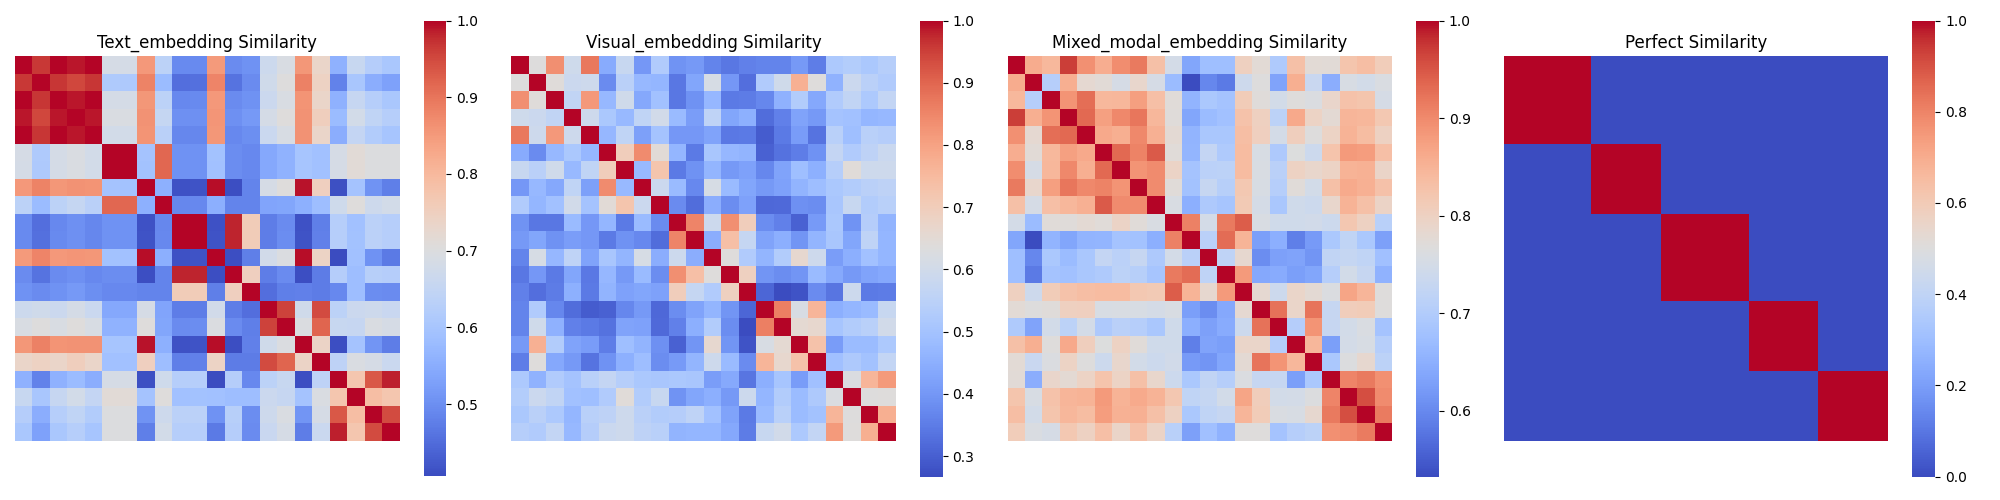

In [47]:
# Function to create a "perfect" similarity matrix
def create_perfect_similarity(num_slides, groups):
    perfect_similarity = np.zeros((num_slides, num_slides))
    for group in groups:
        for i in group:
            for j in group:
                perfect_similarity[i, j] = 1
    return perfect_similarity

# Function to visualize similarity matrices
def visualize_similarity_matrices(similarity_matrices, perfect_similarity=None):
    # Add the perfect similarity matrix if provided
    if perfect_similarity is not None:
        similarity_matrices["Perfect"] = perfect_similarity
    
    # Create subplots
    fig, axes = plt.subplots(1, len(similarity_matrices), figsize=(20, 5))  # Adjust width for extra plot
    for ax, (embedding_type, matrix) in zip(axes, similarity_matrices.items()):
        sns.heatmap(matrix, ax=ax, cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=True, square=True)
        ax.set_title(f"{embedding_type.capitalize()} Similarity")
    plt.tight_layout()
    plt.show()

# Define slide groups (0-indexed)
groups = [
    range(0, 5),   # Slides 1-5 (0-indexed: 0-4)
    range(5, 9),   # Slides 6-9 (0-indexed: 5-8)
    range(9, 14),  # Slides 10-14 (0-indexed: 9-13)
    range(14, 18), # Slides 15-18 (0-indexed: 14-17)
    range(18, 22), # Slides 19-22 (0-indexed: 18-21)
]

# Create the perfect similarity matrix
num_slides = len(slides)
perfect_similarity_matrix = create_perfect_similarity(num_slides, groups)

# Visualize the similarity matrices, including the perfect similarity matrix
visualize_similarity_matrices(similarity_matrices, perfect_similarity=perfect_similarity_matrix)


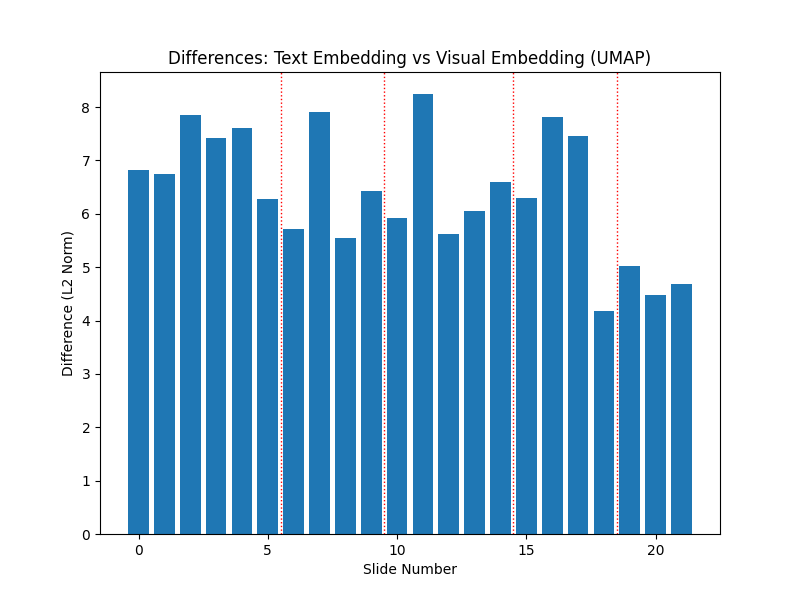

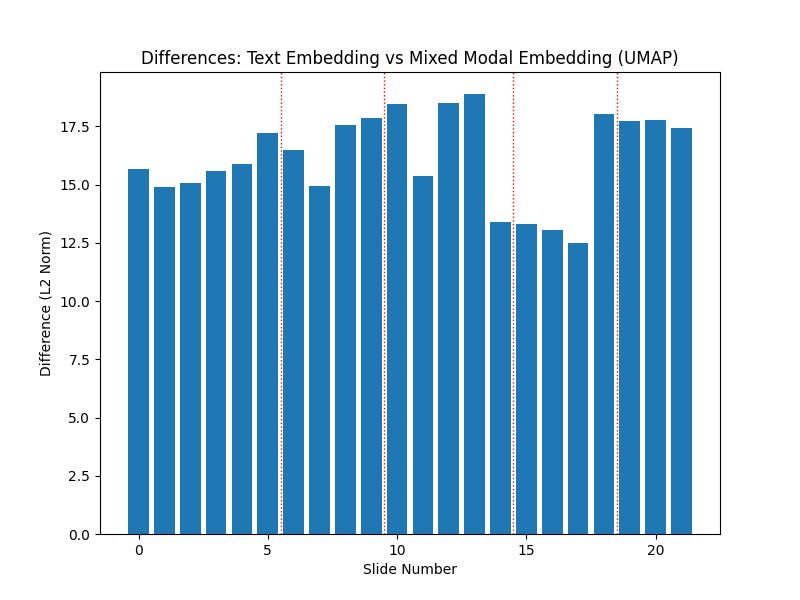

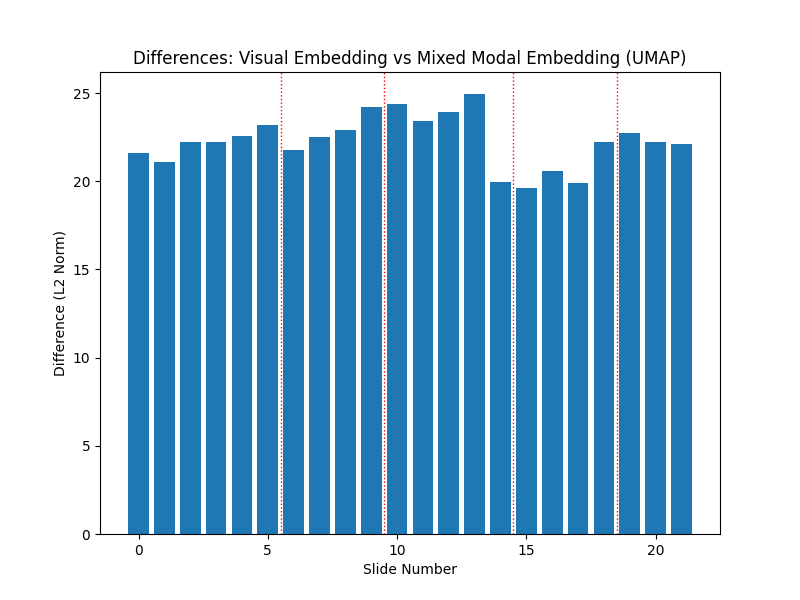

In [42]:
# Function to compute and visualize UMAP embedding differences explicitly for three embedding types
def visualize_umap_differences_explicit(embeddings_df):
    # Extract UMAP columns for each embedding type
    text_umap = embeddings_df[["text_embedding_UMAP0", "text_embedding_UMAP1"]].to_numpy()
    visual_umap = embeddings_df[["visual_embedding_UMAP0", "visual_embedding_UMAP1"]].to_numpy()
    mixed_modal_umap = embeddings_df[["mixed_modal_embedding_UMAP0", "mixed_modal_embedding_UMAP1"]].to_numpy()

    # Compute differences in UMAP space
    text_vs_visual = np.linalg.norm(text_umap - visual_umap, axis=1)
    text_vs_mixed_modal = np.linalg.norm(text_umap - mixed_modal_umap, axis=1)
    visual_vs_mixed_modal = np.linalg.norm(visual_umap - mixed_modal_umap, axis=1)

    # List of x-positions for vertical lines, indicating the beginning of a new Page-Set
    vertical_lines = [5.5, 9.5, 14.5, 18.5]
    
    # Plot differences: Text vs Visual
    plt.figure(figsize=(8, 6))
    plt.bar(embeddings_df["slide_number"], text_vs_visual)
    for line in vertical_lines:
        plt.axvline(x=line, color='red', linestyle='dotted', linewidth=1)
    plt.title("Differences: Text Embedding vs Visual Embedding (UMAP)")
    plt.xlabel("Slide Number")
    plt.ylabel("Difference (L2 Norm)")
    plt.show()

    # Plot differences: Text vs Mixed Modal
    plt.figure(figsize=(8, 6))
    plt.bar(embeddings_df["slide_number"], text_vs_mixed_modal)
    for line in vertical_lines:
        plt.axvline(x=line, color='red', linestyle='dotted', linewidth=1)
    plt.title("Differences: Text Embedding vs Mixed Modal Embedding (UMAP)")
    plt.xlabel("Slide Number")
    plt.ylabel("Difference (L2 Norm)")
    plt.show()

    # Plot differences: Visual vs Mixed Modal
    plt.figure(figsize=(8, 6))
    plt.bar(embeddings_df["slide_number"], visual_vs_mixed_modal)
    for line in vertical_lines:
        plt.axvline(x=line, color='red', linestyle='dotted', linewidth=1)
    plt.title("Differences: Visual Embedding vs Mixed Modal Embedding (UMAP)")
    plt.xlabel("Slide Number")
    plt.ylabel("Difference (L2 Norm)")
    plt.show()

# Visualize UMAP embedding differences explicitly for three embedding types
visualize_umap_differences_explicit(df_umap)

In [43]:
def compute_average_normalized_difference(embeddings_df):
    # Extract UMAP columns for each embedding type
    text_umap = embeddings_df[["text_embedding_UMAP0", "text_embedding_UMAP1"]].to_numpy()
    visual_umap = embeddings_df[["visual_embedding_UMAP0", "visual_embedding_UMAP1"]].to_numpy()
    mixed_modal_umap = embeddings_df[["mixed_modal_embedding_UMAP0", "mixed_modal_embedding_UMAP1"]].to_numpy()

    # Compute differences in UMAP space
    text_vs_visual = np.linalg.norm(text_umap - visual_umap, axis=1)
    text_vs_mixed_modal = np.linalg.norm(text_umap - mixed_modal_umap, axis=1)
    visual_vs_mixed_modal = np.linalg.norm(visual_umap - mixed_modal_umap, axis=1)

    # Compute average differences for each pair of models
    avg_text_vs_visual = np.mean(text_vs_visual) / len(embeddings_df)
    avg_text_vs_mixed_modal = np.mean(text_vs_mixed_modal) / len(embeddings_df)
    avg_visual_vs_mixed_modal = np.mean(visual_vs_mixed_modal) / len(embeddings_df)

    # Store results in a dictionary
    differences = {
        "Text vs Visual": avg_text_vs_visual,
        "Text vs Mixed Modal": avg_text_vs_mixed_modal,
        "Visual vs Mixed Modal": avg_visual_vs_mixed_modal,
    }

    # Find the model pair with the highest normalized average difference
    highest_difference_pair = max(differences, key=differences.get)

    print("Normalized Average Differences:")
    for pair, difference in differences.items():
        print(f"{pair}: {difference:.4f}")

    print(f"\nHighest Difference Pair: {highest_difference_pair} with value {differences[highest_difference_pair]:.4f}")

# Compute and print normalized average differences
compute_average_normalized_difference(df_umap)


Normalized Average Differences:
Text vs Visual: 0.2907
Text vs Mixed Modal: 0.7346
Visual vs Mixed Modal: 1.0131

Highest Difference Pair: Visual vs Mixed Modal with value 1.0131
